In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
# metric in long-term-forecasting
# mae, mse, rmse, mape, mspe

In [3]:
pred_lens = [96, 192, 336, 720]
path = '/data/coding/chaochuan/TSGym/resultsGym'
result_dict = {}
for pred_len in pred_lens:
    model_list = os.listdir(path)
    model_list = [_ for _ in model_list if f'pl{pred_len}' in _]
    result_dict[pred_len] = {}
    for model in model_list:
        try:
            result = np.load(os.path.join(path, model, 'metrics.npy'), allow_pickle=True)
            result_dict[pred_len][model] = result[1]
        except:
            pass
            continue

In [4]:
df = pd.DataFrame.from_dict(result_dict[96], orient='index')
df.columns = ['mse']
# df.sort_values(by='mse').to_csv('gym_96.csv', index=True)
df.sort_values(by='mse').head(20)

,mse
long_term_forecast_ECL_96_96_TSGym_True_DishTS_None_True_series-encoding_MLP_null_True_custom_ftM_sl96_ll48_pl96_dm16_nh8_el2_dl1_df64_expand2_dc4_fc3_ebtimeF_dtTrue_Exp_0,0.211697
long_term_forecast_ECL_96_96_TSGym_True_DishTS_None_True_series-patching_MLP_null_True_custom_ftM_sl96_ll48_pl96_dm16_nh8_el2_dl1_df64_expand2_dc4_fc3_ebtimeF_dtTrue_Exp_0,0.214109
long_term_forecast_ECL_96_96_TSGym_False_DishTS_None_True_series-encoding_MLP_null_True_custom_ftM_sl96_ll48_pl96_dm16_nh8_el2_dl1_df64_expand2_dc4_fc3_ebtimeF_dtTrue_Exp_0,0.216012
long_term_forecast_ECL_96_96_TSGym_False_DishTS_MoEMA_True_series-encoding_MLP_null_True_custom_ftM_sl96_ll48_pl96_dm16_nh8_el2_dl1_df64_expand2_dc4_fc3_ebtimeF_dtTrue_Exp_0,0.216667
long_term_forecast_ECL_96_96_TSGym_True_DishTS_None_True_series-patching_GRU_null_True_custom_ftM_sl96_ll48_pl96_dm16_nh8_el2_dl1_df64_expand2_dc4_fc3_ebtimeF_dtTrue_Exp_0,0.216845
long_term_forecast_ECL_96_96_TSGym_False_DishTS_MA_True_series-encoding_MLP_null_True_custom_ftM_sl96_ll48_pl96_dm16_nh8_el2_dl1_df64_expand2_dc4_fc3_ebtimeF_dtTrue_Exp_0,0.217410
long_term_forecast_ECL_96_96_TSGym_True_None_None_True_series-encoding_MLP_null_True_custom_ftM_sl96_ll48_pl96_dm16_nh8_el2_dl1_df64_expand2_dc4_fc3_ebtimeF_dtTrue_Exp_0,0.218286
long_term_forecast_ECL_96_96_TSGym_True_RevIN_None_True_series-encoding_MLP_null_True_custom_ftM_sl96_ll48_pl96_dm16_nh8_el2_dl1_df64_expand2_dc4_fc3_ebtimeF_dtTrue_Exp_0,0.218303
long_term_forecast_ECL_96_96_TSGym_False_DishTS_None_True_series-patching_Transformer_sparse-attention_True_custom_ftM_sl96_ll48_pl96_dm16_nh8_el2_dl1_df64_expand2_dc4_fc3_ebtimeF_dtTrue_Exp_0,0.218732
long_term_forecast_ECL_96_96_TSGym_True_Stat_None_True_series-encoding_MLP_null_True_custom_ftM_sl96_ll48_pl96_dm16_nh8_el2_dl1_df64_expand2_dc4_fc3_ebtimeF_dtTrue_Exp_0,0.218974


In [5]:
df = pd.DataFrame.from_dict(result_dict[192], orient='index')
df.columns = ['mse']
df.sort_values(by='mse').head(20)
# df.sort_values(by='mse').to_csv('gym_192.csv', index=True)

,mse
long_term_forecast_ECL_96_192_TSGym_True_DishTS_None_True_series-encoding_MLP_null_True_custom_ftM_sl96_ll48_pl192_dm16_nh8_el2_dl1_df64_expand2_dc4_fc3_ebtimeF_dtTrue_Exp_0,0.215303
long_term_forecast_ECL_96_192_TSGym_False_DishTS_None_True_series-encoding_MLP_null_True_custom_ftM_sl96_ll48_pl192_dm16_nh8_el2_dl1_df64_expand2_dc4_fc3_ebtimeF_dtTrue_Exp_0,0.217961
long_term_forecast_ECL_96_192_TSGym_False_DishTS_MA_True_series-encoding_MLP_null_True_custom_ftM_sl96_ll48_pl192_dm16_nh8_el2_dl1_df64_expand2_dc4_fc3_ebtimeF_dtTrue_Exp_0,0.218346
long_term_forecast_ECL_96_192_TSGym_True_RevIN_None_True_series-patching_MLP_null_True_custom_ftM_sl96_ll48_pl192_dm16_nh8_el2_dl1_df64_expand2_dc4_fc3_ebtimeF_dtTrue_Exp_0,0.219825
long_term_forecast_ECL_96_192_TSGym_False_None_MA_True_series-encoding_MLP_null_True_custom_ftM_sl96_ll48_pl192_dm16_nh8_el2_dl1_df64_expand2_dc4_fc3_ebtimeF_dtTrue_Exp_0,0.220055
long_term_forecast_ECL_96_192_TSGym_False_RevIN_MoEMA_True_series-encoding_MLP_null_True_custom_ftM_sl96_ll48_pl192_dm16_nh8_el2_dl1_df64_expand2_dc4_fc3_ebtimeF_dtTrue_Exp_0,0.220293
long_term_forecast_ECL_96_192_TSGym_False_DishTS_MoEMA_True_series-encoding_MLP_null_True_custom_ftM_sl96_ll48_pl192_dm16_nh8_el2_dl1_df64_expand2_dc4_fc3_ebtimeF_dtTrue_Exp_0,0.220362
long_term_forecast_ECL_96_192_TSGym_False_None_None_True_series-encoding_MLP_null_True_custom_ftM_sl96_ll48_pl192_dm16_nh8_el2_dl1_df64_expand2_dc4_fc3_ebtimeF_dtTrue_Exp_0,0.220425
long_term_forecast_ECL_96_192_TSGym_True_DishTS_None_True_series-patching_MLP_null_True_custom_ftM_sl96_ll48_pl192_dm16_nh8_el2_dl1_df64_expand2_dc4_fc3_ebtimeF_dtTrue_Exp_0,0.220513
long_term_forecast_ECL_96_192_TSGym_False_Stat_MoEMA_True_series-encoding_MLP_null_True_custom_ftM_sl96_ll48_pl192_dm16_nh8_el2_dl1_df64_expand2_dc4_fc3_ebtimeF_dtTrue_Exp_0,0.220816


In [6]:
df = pd.DataFrame.from_dict(result_dict[336], orient='index')
df.columns = ['mse']
df.sort_values(by='mse').head(20)
# df.sort_values(by='mse').to_csv('gym_336.csv', index=True)

,mse
long_term_forecast_ECL_96_336_TSGym_True_DishTS_None_True_series-encoding_MLP_null_True_custom_ftM_sl96_ll48_pl336_dm16_nh8_el2_dl1_df64_expand2_dc4_fc3_ebtimeF_dtTrue_Exp_0,0.228604
long_term_forecast_ECL_96_336_TSGym_False_DishTS_None_True_series-encoding_MLP_null_True_custom_ftM_sl96_ll48_pl336_dm16_nh8_el2_dl1_df64_expand2_dc4_fc3_ebtimeF_dtTrue_Exp_0,0.229760
long_term_forecast_ECL_96_336_TSGym_True_None_None_True_series-encoding_MLP_null_True_custom_ftM_sl96_ll48_pl336_dm16_nh8_el2_dl1_df64_expand2_dc4_fc3_ebtimeF_dtTrue_Exp_0,0.230212
long_term_forecast_ECL_96_336_TSGym_False_DishTS_MoEMA_True_series-encoding_MLP_null_True_custom_ftM_sl96_ll48_pl336_dm16_nh8_el2_dl1_df64_expand2_dc4_fc3_ebtimeF_dtTrue_Exp_0,0.232293
long_term_forecast_ECL_96_336_TSGym_True_DishTS_None_True_series-patching_MLP_null_True_custom_ftM_sl96_ll48_pl336_dm16_nh8_el2_dl1_df64_expand2_dc4_fc3_ebtimeF_dtTrue_Exp_0,0.232317
long_term_forecast_ECL_96_336_TSGym_False_DishTS_MA_True_series-encoding_MLP_null_True_custom_ftM_sl96_ll48_pl336_dm16_nh8_el2_dl1_df64_expand2_dc4_fc3_ebtimeF_dtTrue_Exp_0,0.232690
long_term_forecast_ECL_96_336_TSGym_False_None_None_True_series-encoding_MLP_null_True_custom_ftM_sl96_ll48_pl336_dm16_nh8_el2_dl1_df64_expand2_dc4_fc3_ebtimeF_dtTrue_Exp_0,0.232885
long_term_forecast_ECL_96_336_TSGym_True_RevIN_None_True_series-patching_MLP_null_True_custom_ftM_sl96_ll48_pl336_dm16_nh8_el2_dl1_df64_expand2_dc4_fc3_ebtimeF_dtTrue_Exp_0,0.233392
long_term_forecast_ECL_96_336_TSGym_False_None_MA_True_series-encoding_MLP_null_True_custom_ftM_sl96_ll48_pl336_dm16_nh8_el2_dl1_df64_expand2_dc4_fc3_ebtimeF_dtTrue_Exp_0,0.233952
long_term_forecast_ECL_96_336_TSGym_True_RevIN_None_True_series-encoding_MLP_null_True_custom_ftM_sl96_ll48_pl336_dm16_nh8_el2_dl1_df64_expand2_dc4_fc3_ebtimeF_dtTrue_Exp_0,0.234368


In [7]:
df = pd.DataFrame.from_dict(result_dict[720], orient='index')
df.columns = ['mse']
df.sort_values(by='mse').head(20)
# df.sort_values(by='mse').to_csv('gym_720.csv', index=True)

,mse
long_term_forecast_ECL_96_720_TSGym_True_None_None_True_series-encoding_MLP_null_True_custom_ftM_sl96_ll48_pl720_dm16_nh8_el2_dl1_df64_expand2_dc4_fc3_ebtimeF_dtTrue_Exp_0,0.266028
long_term_forecast_ECL_96_720_TSGym_False_DishTS_None_True_series-encoding_MLP_null_True_custom_ftM_sl96_ll48_pl720_dm16_nh8_el2_dl1_df64_expand2_dc4_fc3_ebtimeF_dtTrue_Exp_0,0.266196
long_term_forecast_ECL_96_720_TSGym_True_DishTS_None_True_series-patching_MLP_null_True_custom_ftM_sl96_ll48_pl720_dm16_nh8_el2_dl1_df64_expand2_dc4_fc3_ebtimeF_dtTrue_Exp_0,0.266562
long_term_forecast_ECL_96_720_TSGym_False_None_None_True_series-encoding_MLP_null_True_custom_ftM_sl96_ll48_pl720_dm16_nh8_el2_dl1_df64_expand2_dc4_fc3_ebtimeF_dtTrue_Exp_0,0.266887
long_term_forecast_ECL_96_720_TSGym_False_DishTS_MoEMA_True_series-encoding_MLP_null_True_custom_ftM_sl96_ll48_pl720_dm16_nh8_el2_dl1_df64_expand2_dc4_fc3_ebtimeF_dtTrue_Exp_0,0.267171
long_term_forecast_ECL_96_720_TSGym_False_None_MoEMA_True_series-encoding_MLP_null_True_custom_ftM_sl96_ll48_pl720_dm16_nh8_el2_dl1_df64_expand2_dc4_fc3_ebtimeF_dtTrue_Exp_0,0.268559
long_term_forecast_ECL_96_720_TSGym_False_DishTS_MA_True_series-encoding_MLP_null_True_custom_ftM_sl96_ll48_pl720_dm16_nh8_el2_dl1_df64_expand2_dc4_fc3_ebtimeF_dtTrue_Exp_0,0.269207
long_term_forecast_ECL_96_720_TSGym_True_None_None_True_series-patching_MLP_null_True_custom_ftM_sl96_ll48_pl720_dm16_nh8_el2_dl1_df64_expand2_dc4_fc3_ebtimeF_dtTrue_Exp_0,0.269536
long_term_forecast_ECL_96_720_TSGym_False_None_MA_True_series-encoding_MLP_null_True_custom_ftM_sl96_ll48_pl720_dm16_nh8_el2_dl1_df64_expand2_dc4_fc3_ebtimeF_dtTrue_Exp_0,0.269685
long_term_forecast_ECL_96_720_TSGym_True_DishTS_None_True_series-patching_GRU_null_True_custom_ftM_sl96_ll48_pl720_dm16_nh8_el2_dl1_df64_expand2_dc4_fc3_ebtimeF_dtTrue_Exp_0,0.269698


In [8]:
result_dict_vis = result_dict.copy()
for pred_len in pred_lens:
    result_dict_vis[pred_len] = {k[k.find('TSGym')+6: k.find('custom')-1]:v for k, v in result_dict_vis[pred_len].items()}

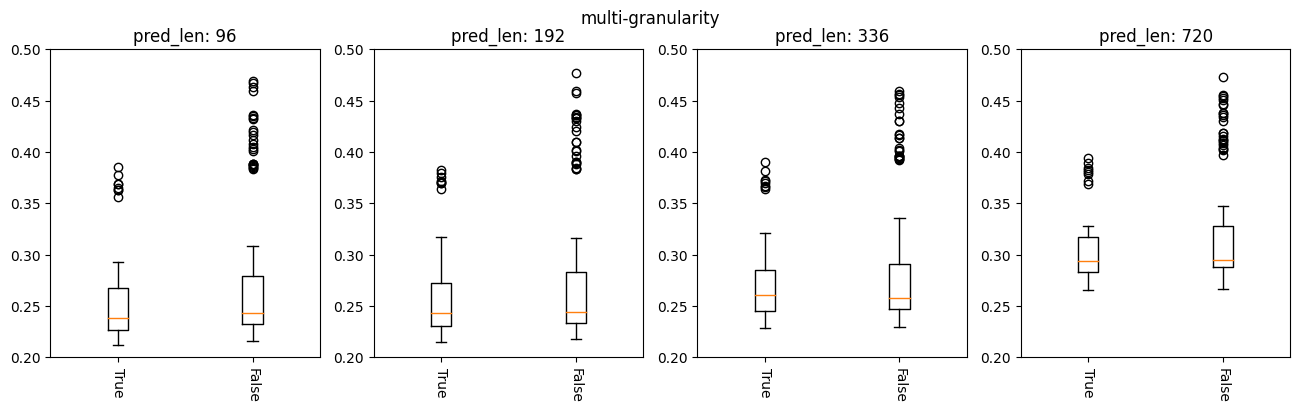

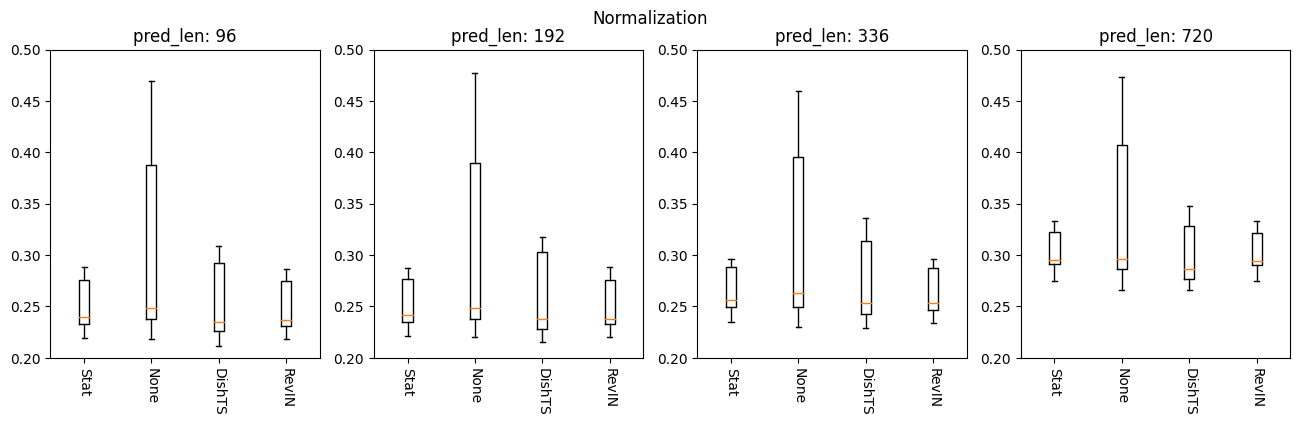

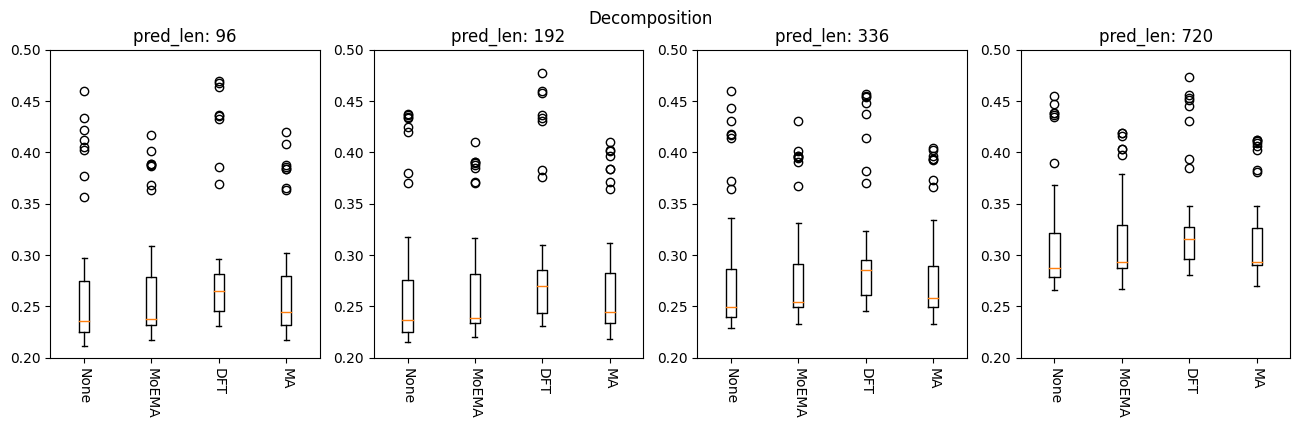

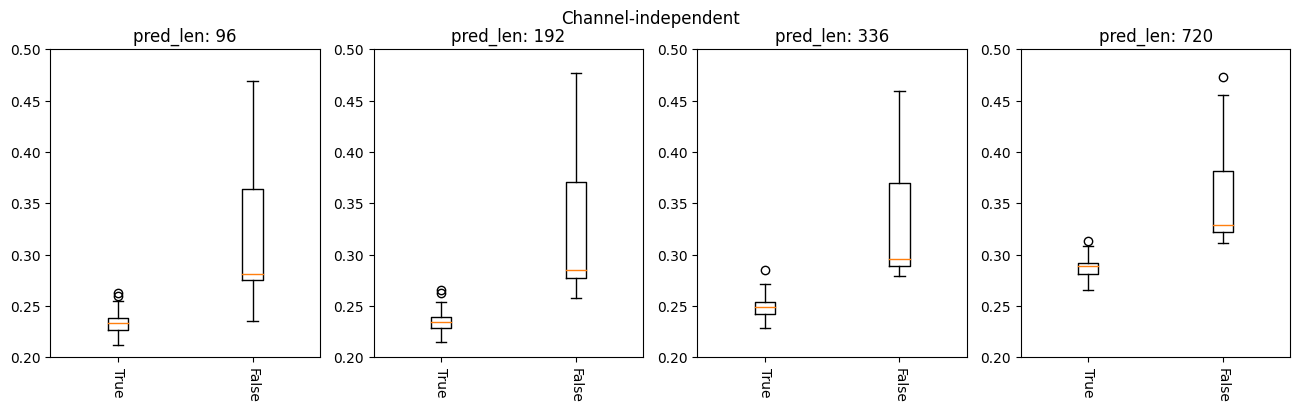

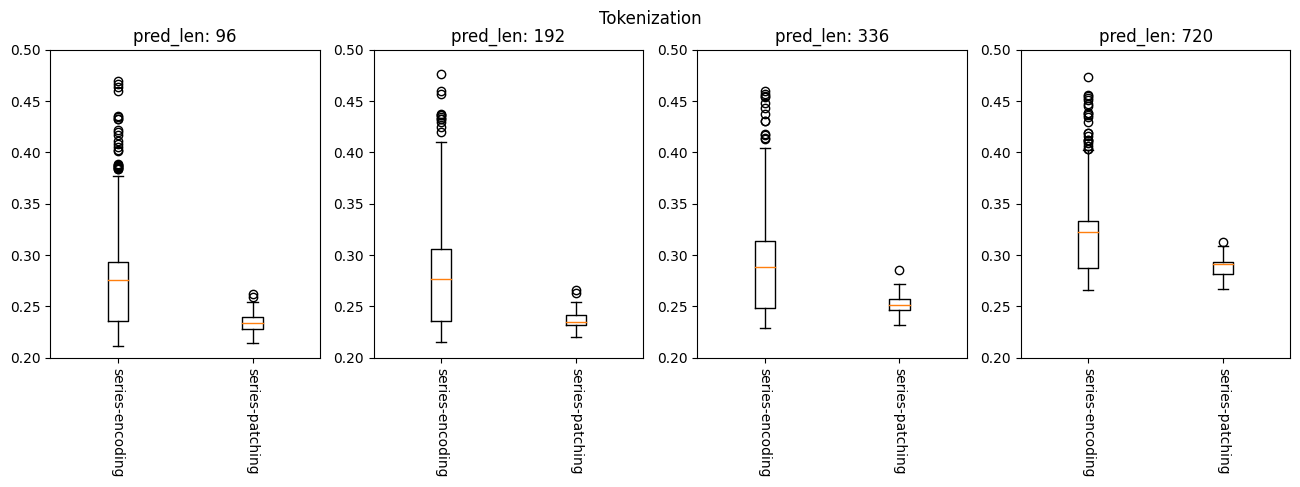

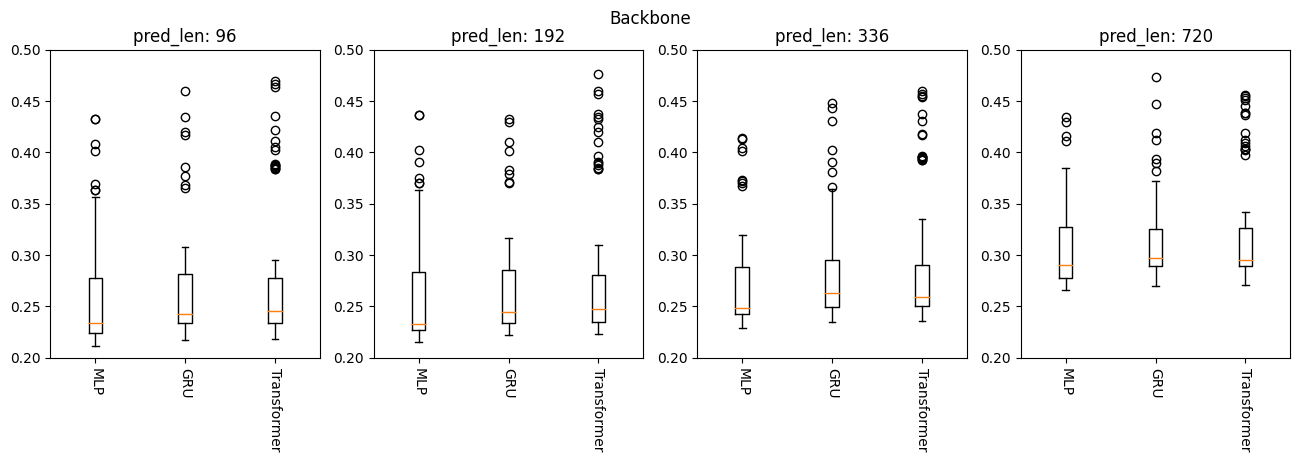

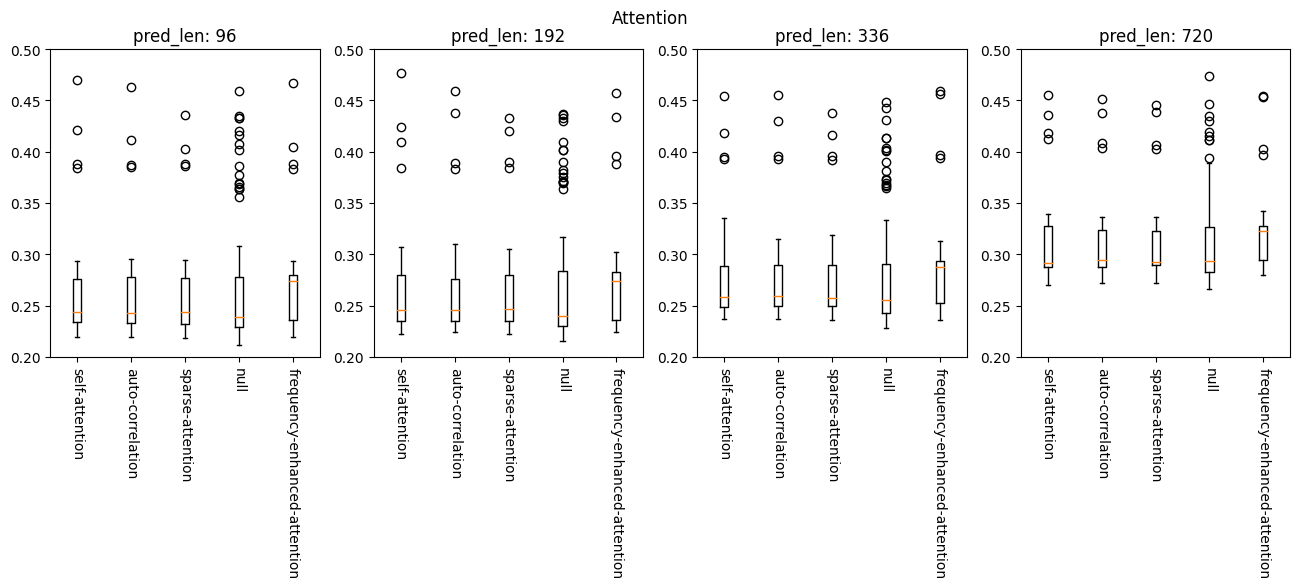

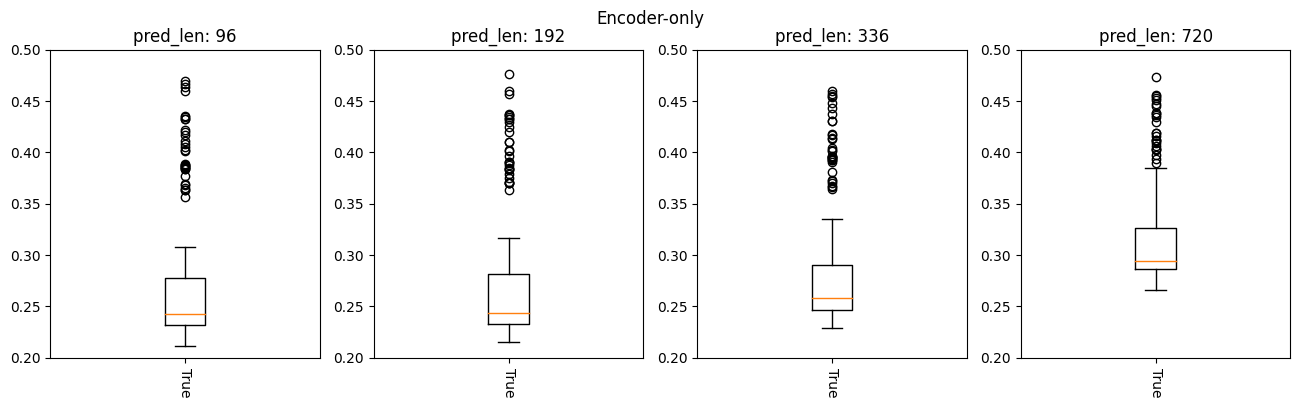

In [10]:
intros = ['multi-granularity', 'Normalization', 'Decomposition', 'Channel-independent', 'Tokenization', 'Backbone', 'Attention', 'Encoder-only']
for n, intro in enumerate(intros):
    fig = plt.figure(figsize=(16, 4))
    for i, pred_len in enumerate(pred_lens):
        result_dict_vis_comp = {}
        fig.add_subplot(1, 4, i+1)
        for j, comp in enumerate(set([_.split('_')[n] for _ in result_dict_vis[pred_len].keys()])):
            result_dict_vis_comp[comp] = {k:v for k, v in result_dict_vis[pred_len].items() if k.split('_')[n] == comp}
            plt.boxplot(result_dict_vis_comp[comp].values(), positions=[j])
            plt.ylim(0.2, 0.5)

        plt.xticks(range(len(result_dict_vis_comp)), result_dict_vis_comp.keys(), rotation=-90)
        plt.title(f'pred_len: {pred_len}')

    fig.suptitle(intro)
    plt.show()